In [46]:
import numpy as np
import pandas as pd 

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

In [92]:
y_true = np.array([True, True, False, False, False, False, False, True, True, False, False, False])
y_pred = np.array([False, True, False, True, True, False, False, True, False, True, False, False])

In [399]:
def plot_binary_confusion_matrix(y_true, y_pred, labels, figsize=(10,10), cmap=plt.cm.Reds):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,), binary array
      y_pred:    prediction of the data, with shape (nsamples,), binary array
      filename:  filename of figure file to save
      labels:    list of labels, first should be the name of negative values
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # true negatives (TN): we predicted N, and they don't have the disease (actual N)
    # false positives (FP): we predicted Y, but they don't have the disease (actual N)
    # false negatives (FN): we predicted N, but they do have the disease (actual Y)
    # true positives (TP): we predicted Y and they do have the disease (actual Y)
    tn, fp, fn, tp = cm.ravel()
    
    # normalzing matrix - getting rates
    cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    
    # tnr (specificity): probability that a test result will be negative when the disease is not present (tn / actual_N)
    # fpr: probability that a test result will be positive when the disease is not present (fp / actual_N)
    # fnr: probability that a test result will be negative when the disease is present (fn / actual_Y)    
    # tpr (recall): probability that a test result will be positive when the disease is present (tp / actual_Y)
    tnr, fpr, fnr, tpr = cm.ravel()
    
    
    # ppv (precision): probability that the disease is present when the test is positive (tp / (tp + fp))
    # npv: probability that the disease is not present when the test is  negative (tn / (tn + fn))
    ppv = tp / (tp + fp) * 100
    npv = tn / (tn + fn) * 100
    
    # Overall, how often is the classifier correct?
    accuracy = (tp + tn) / (tn + fp + fn + tp) * 100

    # The weighted average of recall and precision.
    f_score = 2 * tpr * ppv / (tpr + ppv)
    
    annot = np.empty_like(cm).astype(str)
    annot[0, 0] = 'TN={} \n\nTNR={:.2f}% \n\nNPV={:.2f}%'.format(tn, tnr, npv)
    annot[0, 1] = 'FP={} \n\nFPR={:.2f}%'.format(fp, fpr)
    annot[1, 0] = 'FN={} \n\nFNR={:.2f}%'.format(fn, fnr)
    annot[1, 1] = 'TP={} \n\nTPR={:.2f}% \n\nPPV={:.2f}%'.format(tp, tpr, ppv)
    
    
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cm, annot=annot, annot_kws={"size": 20}, linewidths=0.1, ax=ax,
                    cbar=False, cmap=cmap, linecolor='w', fmt='')
    
    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=12)
    
    # set labels
    ax.axes.set_title("Confusion Matrix",fontsize=20)
    ax.set_xlabel("Predicted label",fontsize=15)
    ax.set_ylabel("Actual label", fontsize=15)
    plt.text(0.7,1.1, 'Accuracy={:.2f}% \n\n F-Score={:.2f}'.format(accuracy, f_score), 
             fontsize=25, color='Orange', fontstyle='oblique')
    
    
    plt.tight_layout()
    plt.show()


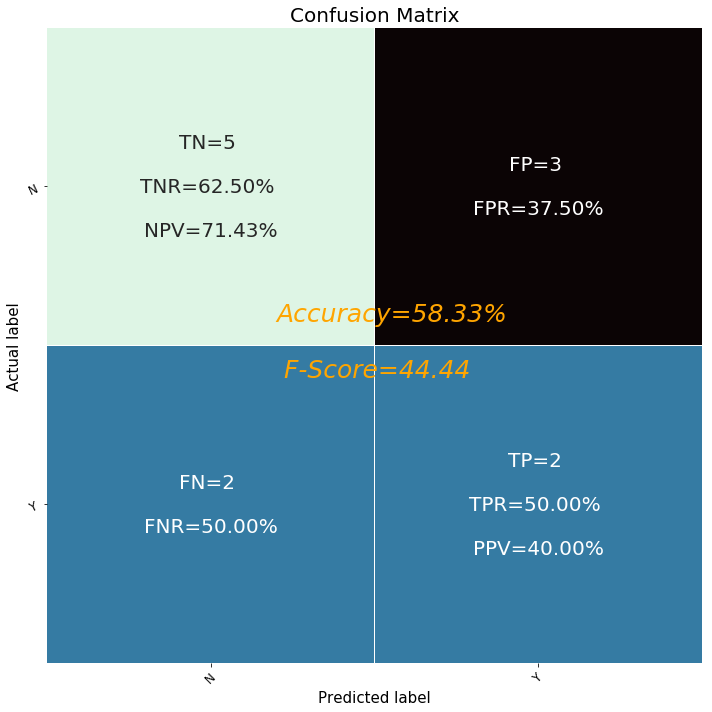

In [400]:
plot_binary_confusion_matrix(y_true, y_pred, ['N', 'Y'], cmap="mako")